<a href="https://colab.research.google.com/github/amitthakur2013/Project_Clg_Tumor_Detection/blob/main/Tumor_Detection_Highly_Accurate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imutils

In [22]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model
import numpy as np
import pandas as pd
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import cv2


from tqdm.notebook import tqdm_notebook as tqdm

import os


In [3]:
image_dir="/content/brain-mri-images/"

In [4]:
os.makedirs('./output/kaggle/working/augmented-images')
os.makedirs('./output/kaggle/working/augmented-images/yes')
os.makedirs('./output/kaggle/working/augmented-images/no')

In [5]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [6]:
augmented_data_path ='./output/kaggle/working/augmented-images/'
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

In [8]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

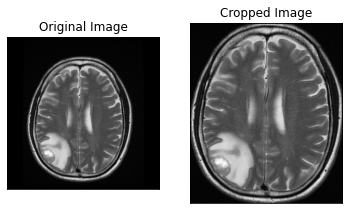

In [9]:
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [10]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [11]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2063
X shape is: (2063, 224, 224, 3)
y shape is: (2063, 1)


In [13]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

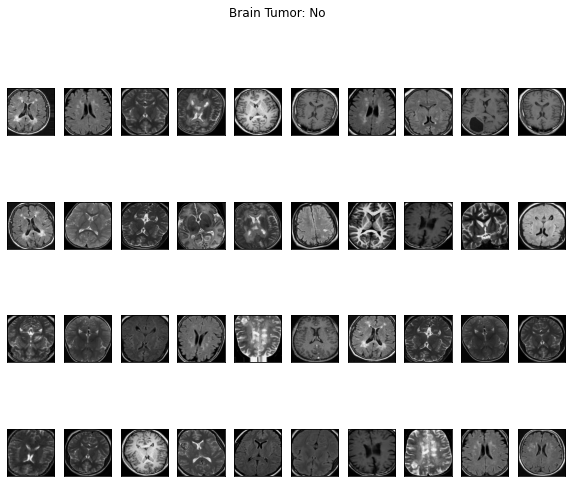

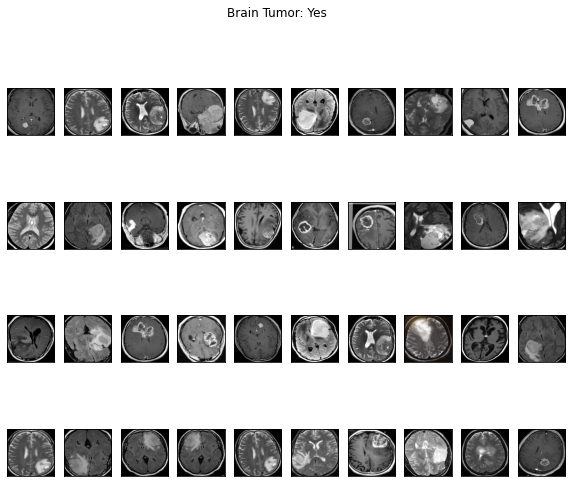

In [14]:
plot_sample_images(X, y)

In [15]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.1)

In [17]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1856
number of validation examples = 104
number of test examples = 103


In [18]:
model=Sequential()
model.add(Conv2D(filters=32, kernel_size=7, input_shape=(224, 224, 3), activation='relu'))
model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(MaxPooling2D(pool_size=4))
model.add(MaxPooling2D(pool_size=4))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 218, 218, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 218, 218, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5409      
Total params: 10,273
Trainable params: 10,209
Non-trainable params: 64
___________________________________________________

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
58/58 [==============================] - 125s 2s/step - loss: 0.6668 - accuracy: 0.6654 - val_loss: 0.6490 - val_accuracy: 0.6058
Epoch 2/22
58/58 [==============================] - 123s 2s/step - loss: 0.4330 - accuracy: 0.8120 - val_loss: 0.6466 - val_accuracy: 0.5865
Epoch 3/22
58/58 [==============================] - 123s 2s/step - loss: 0.3417 - accuracy: 0.8497 - val_loss: 0.5563 - val_accuracy: 0.8077
Epoch 4/22
58/58 [==============================] - 123s 2s/step - loss: 0.3023 - accuracy: 0.8750 - val_loss: 0.5371 - val_accuracy: 0.7308
Epoch 5/22
58/58 [==============================] - 123s 2s/step - loss: 0.2739 - accuracy: 0.8863 - val_loss: 0.5155 - val_accuracy: 0.7308
Epoch 6/22
58/58 [==============================] - 124s 2s/step - loss: 0.2286 - accuracy: 0.9079 - val_loss: 0.4012 - val_accuracy: 0.8558
Epoch 7/22
58/58 [==============================] - 123s 2s/step - loss: 0.2983 - accuracy: 0.8728 - val_loss: 1.0043 - val_accuracy: 0.5481
Epoch 8/22
58

In [20]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 320ms/step - loss: 0.2755 - accuracy: 0.9126


[0.2755049169063568, 0.9126213788986206]

Text(0.5, 1.0, 'Accuracy Curves')

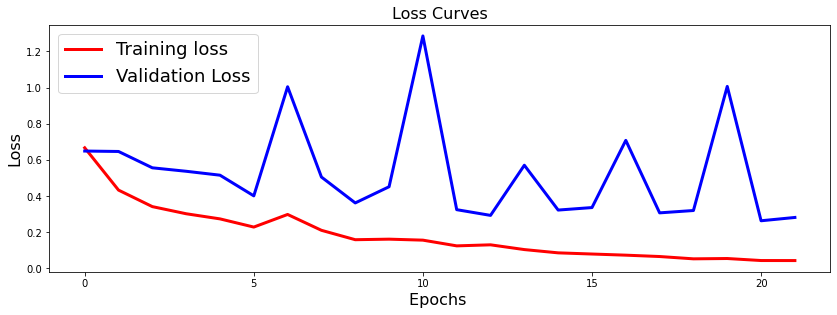

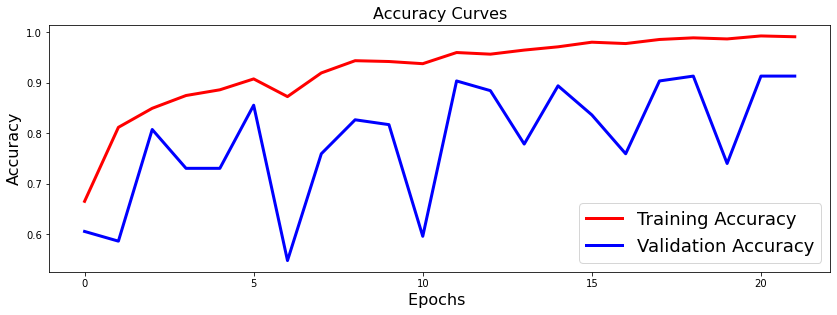

In [21]:

# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
# Model Prediction
from skimage.transform import resize
#image = imread('/content/brain_/Y53.jpg')
image = imread('/content/brain-mri-images/yes/Y1.jpg')
image = resize(image, (224,224,3))
imshow(image)
image = np.expand_dims(image, 1)

#prediction  = model.predict_classes(image)
prediction = np.argmax(model.predict(image), axis=-1)
print(prediction)
"""if prediction[0][0] == 1:
    print("Cancerous Cell")
else:
    print("Non-Cancerous Cell")"""